In [93]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
%matplotlib inline
import model as fxns
from pandas.plotting import scatter_matrix
import scipy as sp

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv('data/churn.csv')

# Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Clean driver ratings

Average rating of driver has ~ 1/5 of dating missing. This is a huge problem going forward, we don't want to just drop 1/5 of our dataset

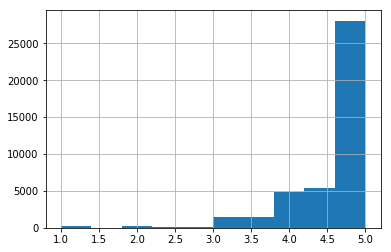

In [4]:
df.avg_rating_of_driver.hist()

As shown above, the distribution is shifted towards 5.0. In this case, where our data is skewed, median is a better representation of the data than the mean. We don't want to just fill Null values with the mode, because then we would be assigning a perfect rating to ~1/5 of our dataset. 

Before we go ahead and replace the null values, lets see if 'no rating of driver' could be its own informative feature

In [5]:
df['no_rating_of_driver'] = pd.isnull(df.avg_rating_of_driver)*1

In [6]:
val1 = (df['no_rating_of_driver']==1)
val2 = (df['no_rating_of_driver']==0)
sp.stats.ttest_ind(val1, val2)

Ttest_indResult(statistic=-289.3957712041854, pvalue=0.0)

The significant difference indicates that 'no_rating_of_driver' is informative

## Bin by rating

Text(0.5, 1.0, 'rating_of_driver')

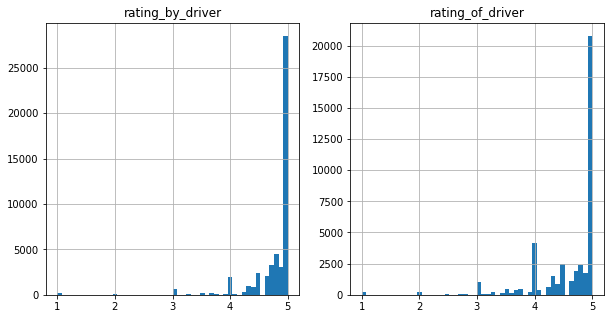

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1 = df.avg_rating_by_driver.hist(bins=50, ax=ax1)
ax1.set_title('rating_by_driver')
ax2 = df.avg_rating_of_driver.hist(bins=50, ax=ax2)
ax2.set_title('rating_of_driver')

It seems like many users give a 5 star rating by default, and not many give below a 4 star rating. A 4 star rating might be skewed, when users dont rate drivers more poorly due to convenience (i.e. being asked more about their experience). 

In [8]:
df['rating_5'] = df.avg_rating_of_driver == 5

We are also going to bin our original average rating of/by driver columns

In [9]:
df['bin_avg_rating_by_driver'] = pd.cut(df.avg_rating_by_driver, bins=[0., 2.99, 3.99, 4.99, 5], 
                                        include_lowest=True, right=True)
df['bin_avg_rating_of_driver'] = pd.cut(df.avg_rating_of_driver, bins=[0., 2.99, 3.99, 4.99, 5], 
                                        include_lowest=True, right=True)

df.bin_avg_rating_by_driver.cat.add_categories('missing', inplace=True)
df.bin_avg_rating_of_driver.cat.add_categories('missing', inplace=True)

df.bin_avg_rating_by_driver.fillna('missing', inplace=True)
df.bin_avg_rating_of_driver.fillna('missing', inplace=True)

Great, now we have a categorical representation of our driver ratings

## Clean phone column

In [10]:
# Filling missing values with no phone, 
# as null values can still be informative
df.phone = df.phone.fillna('no_phone')

### Cleaning Continued...

Our dataset is now relatively clean. To keep things simple, the rest of the code for cleaning is in model.py. Categorical columns were dummied, dropping one of the categories, and numerical data was scaled using standard scaler

In [11]:
df = pd.read_csv('data/churn.csv')

In [12]:
import model as fxns
clean = fxns.Cleaning()
clean.fit(df)
df = clean.all(scale=True)

# EDA

In [13]:
core_features = ['avg_dist', 'avg_surge', 'surge_pct', 
                 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct']
colors = ['red' if ix else 'blue' for ix in df.churn]

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,-2.558398e-17,1.000010,-1.015686,-0.591668,-0.335855,0.200300,27.186793
avg_surge,50000.0,6.134493e-16,1.000010,-0.336268,-0.336268,-0.336268,-0.111381,31.147926
surge_pct,50000.0,8.276602e-16,1.000010,-0.443394,-0.443394,-0.443394,-0.012503,4.566974
trips_in_first_30_days,50000.0,-8.546253e-16,1.000010,-0.600689,-0.600689,-0.337021,0.190316,32.357830
weekday_pct,50000.0,1.350848e-15,1.000010,-1.643048,-0.745017,0.155710,1.053741,1.053741
churn,50000.0,6.239200e-01,0.484405,0.000000,0.000000,1.000000,1.000000,1.000000
rating_5,50000.0,4.154200e-01,0.492799,0.000000,0.000000,0.000000,1.000000,1.000000
no_rating_of_driver,50000.0,1.624400e-01,0.368858,0.000000,0.000000,0.000000,0.000000,1.000000
luxury_car_user,50000.0,3.770800e-01,0.484660,0.000000,0.000000,0.000000,1.000000,1.000000
city_King's Landing,50000.0,2.026000e-01,0.401941,0.000000,0.000000,0.000000,0.000000,1.000000


In [15]:
df.corr()

,avg_dist,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,churn,rating_5,no_rating_of_driver,luxury_car_user,city_King's Landing,city_Winterfell,phone_iPhone,phone_no_phone,"bin_avg_rating_of_driver_(2.99, 3.99]","bin_avg_rating_of_driver_(3.99, 4.99]","bin_avg_rating_of_driver_(4.99, 5.0]",bin_avg_rating_of_driver_missing,"bin_avg_rating_by_driver_(2.99, 3.99]","bin_avg_rating_by_driver_(3.99, 4.99]","bin_avg_rating_by_driver_(4.99, 5.0]",bin_avg_rating_by_driver_missing
avg_dist,1.000000,-0.081491,-0.104414,-0.136329,0.101652,0.092780,0.042222,0.131905,0.032310,0.015877,0.030050,-0.025030,0.022372,-0.043726,-0.124519,0.042222,0.131905,-0.014014,-0.180956,0.184331,0.004122
avg_surge,-0.081491,1.000000,0.793582,-0.001841,-0.110071,0.003333,-0.012659,0.006826,-0.078791,-0.009198,-0.027643,0.011104,-0.011423,0.008751,-0.000830,-0.012659,0.006826,-0.007137,-0.009505,0.008361,0.026019
surge_pct,-0.104414,0.793582,1.000000,0.005720,-0.144918,-0.011797,-0.004232,-0.006652,-0.106861,0.028221,-0.065603,0.012851,-0.014456,0.002083,0.007193,-0.004232,-0.006652,-0.011326,-0.002618,0.004227,0.021980
trips_in_first_30_days,-0.136329,-0.001841,0.005720,1.000000,0.050388,-0.210463,-0.133649,-0.195643,0.112210,0.024650,0.037735,0.058342,0.002786,0.043127,0.273674,-0.133649,-0.195643,-0.047171,0.363203,-0.334305,-0.028912
weekday_pct,0.101652,-0.110071,-0.144918,0.050388,1.000000,-0.009693,-0.001779,-0.022270,0.035998,0.031349,-0.015318,0.006726,0.012753,-0.003434,0.023906,-0.001779,-0.022270,-0.021403,0.017139,-0.006881,-0.013179
churn,0.092780,0.003333,-0.011797,-0.210463,-0.009693,1.000000,0.115836,0.159232,-0.205002,-0.262284,0.046611,-0.225244,0.007419,-0.040512,-0.229043,0.115836,0.159232,0.045794,-0.346028,0.316616,0.025834
rating_5,0.042222,-0.012659,-0.004232,-0.133649,-0.001779,0.115836,1.000000,-0.371245,-0.043070,0.059453,-0.080394,-0.036915,-0.008473,-0.217138,-0.613020,1.000000,-0.371245,-0.010315,-0.173716,0.175948,0.008659
no_rating_of_driver,0.131905,0.006826,-0.006652,-0.195643,-0.022270,0.159232,-0.371245,1.000000,-0.036656,-0.048904,0.017531,-0.056298,0.019375,-0.113437,-0.320252,-0.371245,1.000000,0.020607,-0.254800,0.231669,0.029435
luxury_car_user,0.032310,-0.078791,-0.106861,0.112210,0.035998,-0.205002,-0.043070,-0.036656,1.000000,0.039649,-0.051990,0.067002,0.043145,0.015359,0.067618,-0.043070,-0.036656,-0.022034,0.106409,-0.090926,-0.027256
city_King's Landing,0.015877,-0.009198,0.028221,0.024650,0.031349,-0.262284,0.059453,-0.048904,0.039649,1.000000,-0.471555,0.060520,-0.009111,-0.039404,0.003142,0.059453,-0.048904,-0.033971,-0.026031,0.040334,-0.000568


In [16]:
df['bin_avg_rating_by_driver_missing'].sum()

201

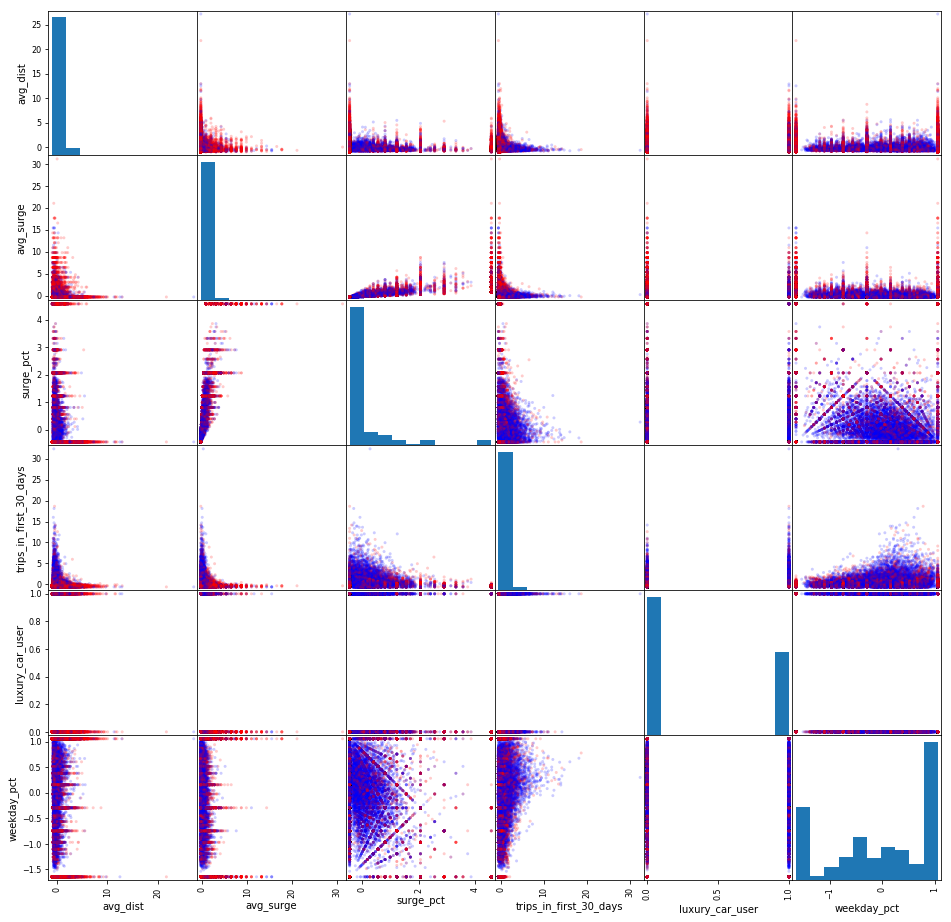

In [17]:
scat = scatter_matrix(df[core_features], 
               alpha=0.2, figsize=(16, 16), 
               diagonal='hist', color=colors)

# Build Model

In [18]:
df = pd.read_csv('data/churn.csv')
import model as fxns
clean = fxns.Cleaning()
clean.fit(df)
df = clean.all(scale=True)
df = clean.drop_dt()

In [19]:
df.head()

,avg_dist,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,churn,rating_5,no_rating_of_driver,luxury_car_user,city_King's Landing,city_Winterfell,phone_iPhone,phone_no_phone,"bin_avg_rating_of_driver_(2.99, 3.99]","bin_avg_rating_of_driver_(3.99, 4.99]","bin_avg_rating_of_driver_(4.99, 5.0]",bin_avg_rating_of_driver_missing,"bin_avg_rating_by_driver_(2.99, 3.99]","bin_avg_rating_by_driver_(3.99, 4.99]","bin_avg_rating_by_driver_(4.99, 5.0]",bin_avg_rating_by_driver_missing
0,-0.372650,0.113506,0.328202,0.453984,-0.397131,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0
1,0.431583,-0.336268,-0.443394,-0.600689,-0.294653,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,-0.880771,-0.336268,-0.443394,0.190316,1.053741,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
3,-0.602181,0.293416,0.558679,1.772325,0.514383,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0
4,-0.467266,0.518303,0.147829,3.090665,0.579106,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0


In [20]:
y = df.churn.values
X = df.drop('churn', axis=1).values

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [22]:
rf = GradientBoostingClassifier()
gb = RandomForestClassifier()

### Random Forest Model

In [23]:
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7882

Going to now run CV to get a better idea of score

In [24]:
mod = fxns.Model()
mod.fit(df)
cv_score_rf = np.mean(mod.CV(rf.fit(X_train, y_train)))

print('Random Forest CV accuracy (10-Fold): {}'.format(cv_score_rf))

Random Forest CV accuracy (10-Fold): 0.7854000000000001


In [25]:
y_hat = rf.predict(X_test)

##Evaluating Model Performance
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Precision:",metrics.precision_score(y_test, y_hat))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_hat))

Precision: 0.8123501199040767
Recall: 0.8622335348393255


### Gradient Boosting Model

In [26]:
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

/Users/kylecaron/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7441

Going to now run CV to get a better idea of score

In [27]:
cv_score_gb = np.mean(mod.CV(gb.fit(X_train, y_train)))
print('GB accuracy (10-Fold): {}'.format(cv_score_gb))

GB accuracy (10-Fold): 0.739525


In [28]:
y_hat = gb.predict(X_test)

##Evaluating Model Performance
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_hat))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_hat))

Precision: 0.8090834021469859
Recall: 0.7793509385937003


## Roc Curve

In [29]:
from sklearn.metrics import roc_curve

In [30]:
fpr, tpr, thresholds = roc_curve(
    y_test, gb.predict_proba(X_test)[:,1])

fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    y_test, rf.predict_proba(X_test)[:,1])

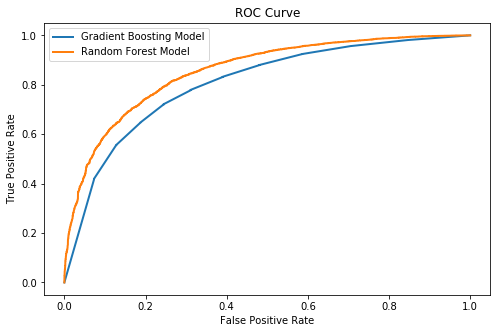

In [31]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(fpr, tpr, lw=2, alpha=1,label='Gradient Boosting Model')
ax.plot(fpr_rf, tpr_rf, lw=2, alpha=1,label='Random Forest Model')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.show()

In [32]:
import sklearn.metrics as skm
skm.roc_auc_score(y_test, rf.predict(X_test))

0.7625653403868142

In [33]:
import sklearn.metrics as skm
skm.roc_auc_score(y_test, gb.predict(X_test))

0.7340481133463924

## Confusion Matrices

Confusion matrix, without normalization
[[2558 1156]
 [1387 4899]]
Confusion matrix, without normalization
[[2462 1252]
 [ 866 5420]]


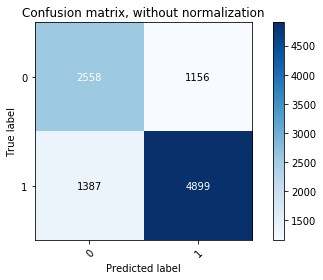

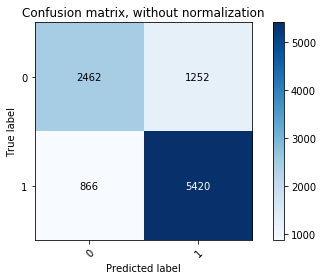

In [34]:
from sklearn.metrics import confusion_matrix

fxns.plot_confusion_matrix(y_test, gb.predict(X_test))
fxns.plot_confusion_matrix(y_test, rf.predict(X_test))

## Feature Importances

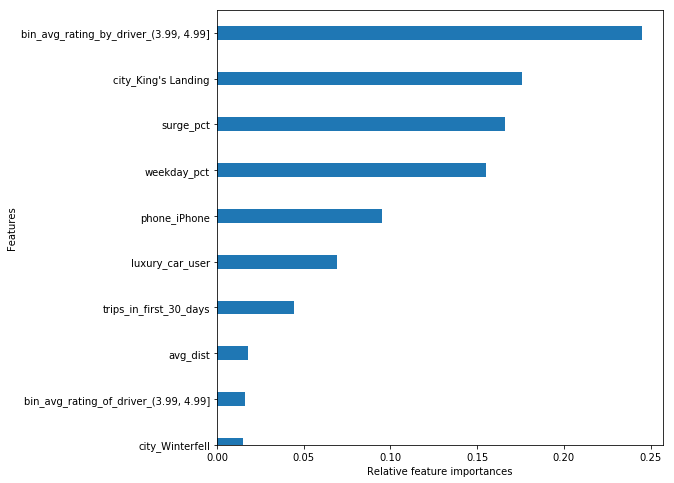

In [35]:
mod.importance(rf.fit(X_train, y_train))

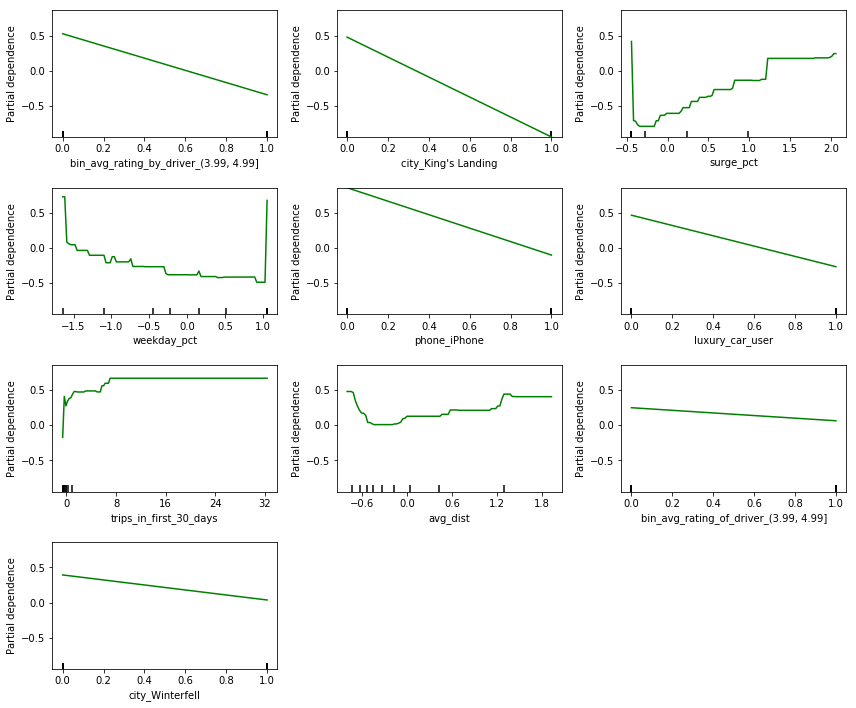

In [36]:
mod.plot_partial_dependencies(rf)

# Grid Searching

In [37]:
from sklearn.model_selection import GridSearchCV

### Gradient Boosting

In [72]:
gb_grid = {
    'learning_rate': [1.0, 0.5, 0.01],
    'max_depth': [1, 3, 8],
    'min_samples_leaf': [3],
    'max_features': ['sqrt', 'log2', None ],
    'n_estimators': [500, 1000],
    'subsample': [0.5, 0.75, 1.0]
}
gb_grid_cv = GridSearchCV(GradientBoostingClassifier(), 
                           gb_grid, n_jobs=-1, cv=3,
                         scoring='roc_auc')

In [75]:
gb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [1.0, 0.5, 0.01], 'max_depth': [1, 3, 8], 'min_samples_leaf': [3], 'max_features': ['sqrt', 'log2', None], 'n_estimators': [500, 1000], 'subsample': [0.5, 0.75, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [76]:
best_gb_model = gb_grid_cv.best_estimator_
best_gb_params = gb_grid_cv.best_params_
best_gb_params

{'learning_rate': 0.01,
 'max_depth': 8,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'n_estimators': 1000,
 'subsample': 0.5}

In [77]:
gb_grid_cv.best_score_

0.8548819258888724

#### Plot Loss

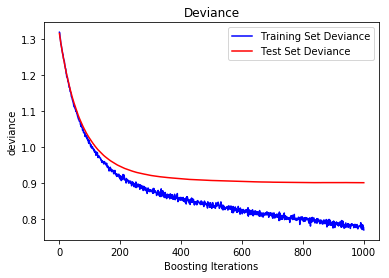

In [79]:
fxns.plot_loss(best_gb_model, best_gb_params, X_test, y_test)

### Random Forest

In [50]:
rf_grid = {
    'max_depth': [4, 8, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True], # Mandatory with oob_score=True
    'n_estimators': [50, 100, 200, 400],
    'random_state': [67],
    'oob_score': [True],
    'n_jobs': [-1]
    }
rf_grid_cv = GridSearchCV(RandomForestClassifier(),
                             rf_grid, cv=3,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')

In [51]:
rf_grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 14.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [4, 8, None], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True], 'n_estimators': [50, 100, 200, 400], 'random_state': [67], 'oob_score': [True], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [52]:
best_rf_params = rf_grid_cv.best_params_
best_rf_params

{'bootstrap': True,
 'max_depth': 8,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 400,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 67}

In [53]:
best_rf_model = rf_grid_cv.best_estimator_
rf_grid_cv.best_score_

0.8448174787951641

# Choosing a model

Since our data is slightly unbalanced, ROC AUC score is a better evaluator than accuracy. The Gradient Boosting Model marginally outperformed Random Forest, and by nature it is better equipped to handle unbalanced data, so we are using it going forward

# Partial Dependence with unscaled data

In [80]:
df = pd.read_csv('data/churn.csv')
import model as fxns
clean = fxns.Cleaning()
clean.fit(df)
df = clean.all(scale=False)
df = clean.drop_dt()

In [81]:
y = df.churn.values
X = df.drop('churn', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

mod = fxns.Model()
mod.fit(df)
np.mean(mod.CV(best_gb_model))

0.8568711674579379

Confusion matrix, without normalization
[[2693 1107]
 [ 720 5480]]


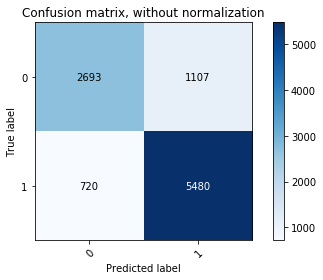

In [120]:
fxns.plot_confusion_matrix(y_test, best_gb_model.predict(X_test))

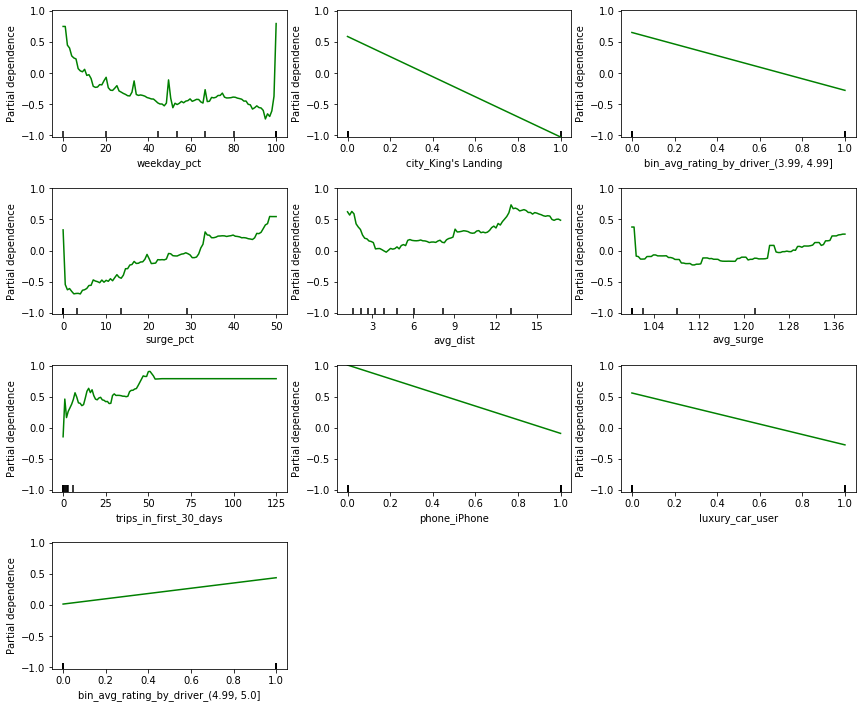

In [70]:
mod.plot_partial_dependencies(best_gb_model)

The following should be monitored due to increased risk of churn:
    - Average rating by driver less than 5.0
    - Greater than 35% surge pct 
    - Be more worried about android users, consider making a better 
        application for android phones

Certain cities should also be looked at. King's landing has a drastically reduced chance of churn